# Fashion MNIST Bayesian

What it means and what you can do about it!

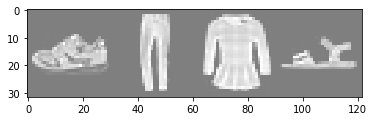

Sneaker Trouser T-shirt/top Sandal


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.tensorboard import SummaryWriter

from blitz.modules import BayesianLinear, BayesianConv2d
from blitz.losses import kl_divergence_from_nn
from blitz.utils import variational_estimator

trainset = torchvision.datasets.FashionMNIST(root='./data', train=True,
                                             download=True,
                                             transform=transforms.Compose([transforms.ToTensor()]))
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.FashionMNIST(root='./data', train=False,
                                            download=True,
                                            transform=transforms.Compose([transforms.ToTensor()]))
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

classes = (
    'T-shirt/top',
    'Trouser',
    'Pullover',
    'Dress',
    'Coat',
    'Sandal',
    'Shirt',
    'Sneaker',
    'Bag',
    'Ankle boot'
)

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# Initialize tensorboard
writer = SummaryWriter('runs/fashion_mnist')


# get some random training images
dataiter = iter(trainloader)
testImages, testLabels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(testImages))
# print labels
print(' '.join('%5s' % classes[testLabels[j]] for j in range(4)))

# 2. Define a convolutional neural network


In [2]:
@variational_estimator
class BayesianCNN(nn.Module):
    def __init__(self):
        super(BayesianCNN, self).__init__()
        self.conv1 = BayesianConv2d(1, 6, (5,5)) # 6 filters, size 5x5,            output size = 24x24
        self.pool = nn.MaxPool2d(2,2)
        self.conv2 = BayesianConv2d(6,16, (3,3)) # 16 filters, size 3x3,           outSize = 10x10

        # Define function
        self.fc1 = BayesianLinear(16*5*5, 160)
        self.fc2 = BayesianLinear(160, 120)
        self.fc3 = BayesianLinear(120, 84)
        self.fc4 = BayesianLinear(84, 10)

    def forward(self, x):
        # First convolution and max pooling
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16*5*5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return x

def evaluate_classifier(classifier, X, y, samples=100, std_multiplier=2):
    preds = [classifier(X) for i in range(samples)]
    preds = torch.stack(preds)
    means = preds.mean(axis=0)
    stds = preds.std(axis=0)


    return preds, means, stds



# 3. Define a Loss function and optimizer and train the network

In [ ]:
import torch.optim as optim

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
classifier = BayesianCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(classifier.parameters(), lr=0.001)
plot_step = 0

for epoch in range (2):
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        loss = classifier.sample_elbo(inputs=inputs.to(device),
        labels=labels.to(device),
        criterion=criterion,
        sample_nbr=3)

        loss.backward()
        optimizer.step()

        if i % 1000 == 0:
            # Add data to tensorboard
            writer.add_scalar("Loss/train", loss, plot_step)

            #preds, means, stds = evaluate_classifier(classifier, testImages, testLabels)

            #print(means)
            print('[%d, %5d] loss: %.3f' % (epoch, i, loss))
            plot_step = plot_step + 1

print('Finished training')
writer.flush()

# Save data
PATH = './model/trained_koen_bay.pth'
torch.save(classifier.state_dict(), PATH)



# 4. Test the network

tensor([[-0.3589,  0.1870,  0.0024,  0.0939, -0.2620,  0.0311,  0.0842, -0.3216,
          0.0325, -0.1831],
        [-0.5318,  0.0700,  0.0685,  0.2774, -0.2756,  0.2153, -0.0249, -0.3712,
          0.0136, -0.2039],
        [-0.4128,  0.0992,  0.0833,  0.3122, -0.2382,  0.0914, -0.0047, -0.3601,
          0.0191, -0.0998],
        [-0.3416,  0.1208,  0.0656,  0.2757, -0.2273,  0.0928,  0.0147, -0.3276,
          0.0106, -0.0962]], grad_fn=<MeanBackward1>)
tensor([[0.0063, 0.0048, 0.0060, 0.0051, 0.0052, 0.0050, 0.0048, 0.0057, 0.0055,
         0.0054],
        [0.0109, 0.0065, 0.0082, 0.0086, 0.0079, 0.0085, 0.0059, 0.0070, 0.0063,
         0.0058],
        [0.0074, 0.0073, 0.0061, 0.0077, 0.0058, 0.0061, 0.0051, 0.0069, 0.0051,
         0.0052],
        [0.0060, 0.0059, 0.0052, 0.0058, 0.0049, 0.0052, 0.0048, 0.0063, 0.0042,
         0.0044]], grad_fn=<StdBackward1>)


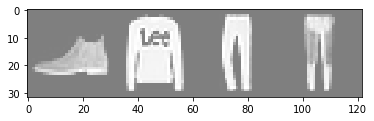

Predition:  9.000000 2.000000 1.000000 1.000000


In [20]:
PATH = './model/trained_koen_bay.pth'
dataiter = iter(testloader)
images, labels = dataiter.next()

# load the trained model
classifier = BayesianCNN()
classifier.load_state_dict(torch.load(PATH))

pred, means, stds = evaluate_classifier(classifier, images, labels)

#print(pred)
print(means)
print(stds)

# pints images
imshow(torchvision.utils.make_grid(images))
print('Predition: ', ' '.join('%5f' % labels[j] for j in range(4)))


# 4. Create tensorboard


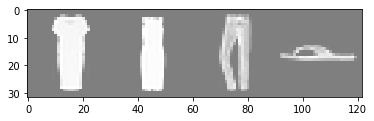

In [55]:
dataiter = iter(trainloader)
images, labels = dataiter.next()

img_grid = torchvision.utils.make_grid(images)

imshow(img_grid)

writer.add_image('four_fashion_mnist_images', img_grid)
writer.add_graph(net, images)
writer.close()

